## 고객의 정기예금 가입 여부 예측을 위한 은행 마케팅 분류 모델 구축

## 1.분석 목적 및 목표

- 분석 목적 : 포르투갈 A은행의 마케팅 담당자로서 **고객이 정기 예금을 가입할 가능성을 예측**하고자 정기 예금과 관련이 있는 요소들을 파악하여 마케팅 캠페인의 효율성 제고
- 분석 목표 : 결정 트리와 앙상블 기법을 사용하여 고객이 정기 예금을 가입할지 여부를 예측하는 분류 모델을 구축하여 인사이트를 바탕으로 비즈니스 전략 제시

In [63]:
!pip install optuna-integration[sklearn]

zsh:1: no matches found: optuna-integration[sklearn]


In [64]:
# 라이브러리
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import optuna
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling  import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings

In [65]:
pd.options.mode.chained_assignment = None # 경고 메시지 중 SettingWithCopyWarning을 방지
warnings.filterwarnings("ignore", category=DeprecationWarning) # 불필요한 경고 메시지를 무시
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## 2.데이터 소개
- UC Irvine Machine Learning Repository에서 제공하는 [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing) 데이터
- 2008년 부터 2010년까지의 포르투갈 은행의 마케팅 캠페인 결과를 설명하는 데이터셋
- 전화 통화 기반 마케팅 캠페인으로서 고객이 정기 예금을 가입하기로 동의했다면 목표변수(target)y에 `yes`라고 표시

| 컬럼명              | 설명                                 |
|--------------------|--------------------------------------|
| age                | 나이 (숫자)                          |
| job                | 직업 (범주형)                        |
| marital            | 결혼 여부 (범주형)                  |
| education          | 교육 수준 (범주형)                  |
| default            | 신용 불량 여부 (범주형)             |
| housing            | 주택 대출 여부 (범주형)             |
| loan               | 개인 대출 여부 (범주형)             |
| contact            | 연락 유형 (범주형)                  |
| month              | 마지막 연락 월 (범주형)              |
| day_of_week        | 마지막 연락 요일 (범주형)            |
| duration           | 마지막 연락 지속 시간, 초 단위 (숫자)|
| campaign           | 캠페인 동안 연락 횟수 (숫자)        |
| pdays              | 이전 캠페인 후 지난 일수 (숫자)     |
| previous           | 이전 캠페인 동안 연락 횟수 (숫자)   |
| poutcome           | 이전 캠페인의 결과 (범주형)         |
| emp.var.rate       | 고용 변동률 (숫자)                  |
| cons.price.idx     | 소비자 물가지수 (숫자)              |
| cons.conf.idx      | 소비자 신뢰지수 (숫자)              |
| euribor3m         | 3개월 유리보 금리 (숫자)            |
| nr.employed        | 고용자 수 (숫자)                    |
| y                  | 정기 예금 가입 여부 (이진: yes=1, no=0) |


-  Input variables:
- bank client data:
    1. age (numeric)
    2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
    3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
    4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
    5. default: has credit in default? (categorical: "no","yes","unknown")
    6. housing: has housing loan? (categorical: "no","yes","unknown")
    7. loan: has personal loan? (categorical: "no","yes","unknown")
    - related with the last contact of the current campaign:
    8. contact: contact communication type (categorical: "cellular","telephone")
    9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
    10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
    11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- other attributes:
    12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    14. previous: number of contacts performed before this campaign and for this client (numeric)
    15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
    - social and economic context attributes
    16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
    17. cons.price.idx: consumer price index - monthly indicator (numeric)     
    18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
    19. euribor3m: euribor 3 month rate - daily indicator (numeric)
    20. nr.employed: number of employees - quarterly indicator (numeric)

-  Output variable (desired target):
    21. y - has the client subscribed a term deposit? (binary: "yes","no")

## 3.데이터 불러오기

In [66]:
file_path = 'bank-additional-full.csv'
data = pd.read_csv(file_path, sep=';')

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

- 데이터셋은 41,188행과 21열로 결측치는 관찰되지 않음

In [68]:
# 중복값 확인
data.duplicated().sum()

np.int64(12)

In [69]:
data[data.duplicated(keep=False)]#.duplicated()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


- 총 12건의 중복 데이터가 관찰되었고 불필요한 값이라고 판단되어 제거하였다

In [70]:
# 중복값 제거
data = data.drop_duplicates()
data = data.reset_index(drop=True)

## 4.EDA

In [71]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [72]:
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551,36537


In [73]:
data['y'].value_counts(normalize=True)

y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64

- 목표변수는 89%의 '아니오'와 11%의 '예'의 답으로 불균형한 형태를 가지고있다.
- 데이터 불균형을 SMOTE를 활용하여 실험을 진행하고자 한다

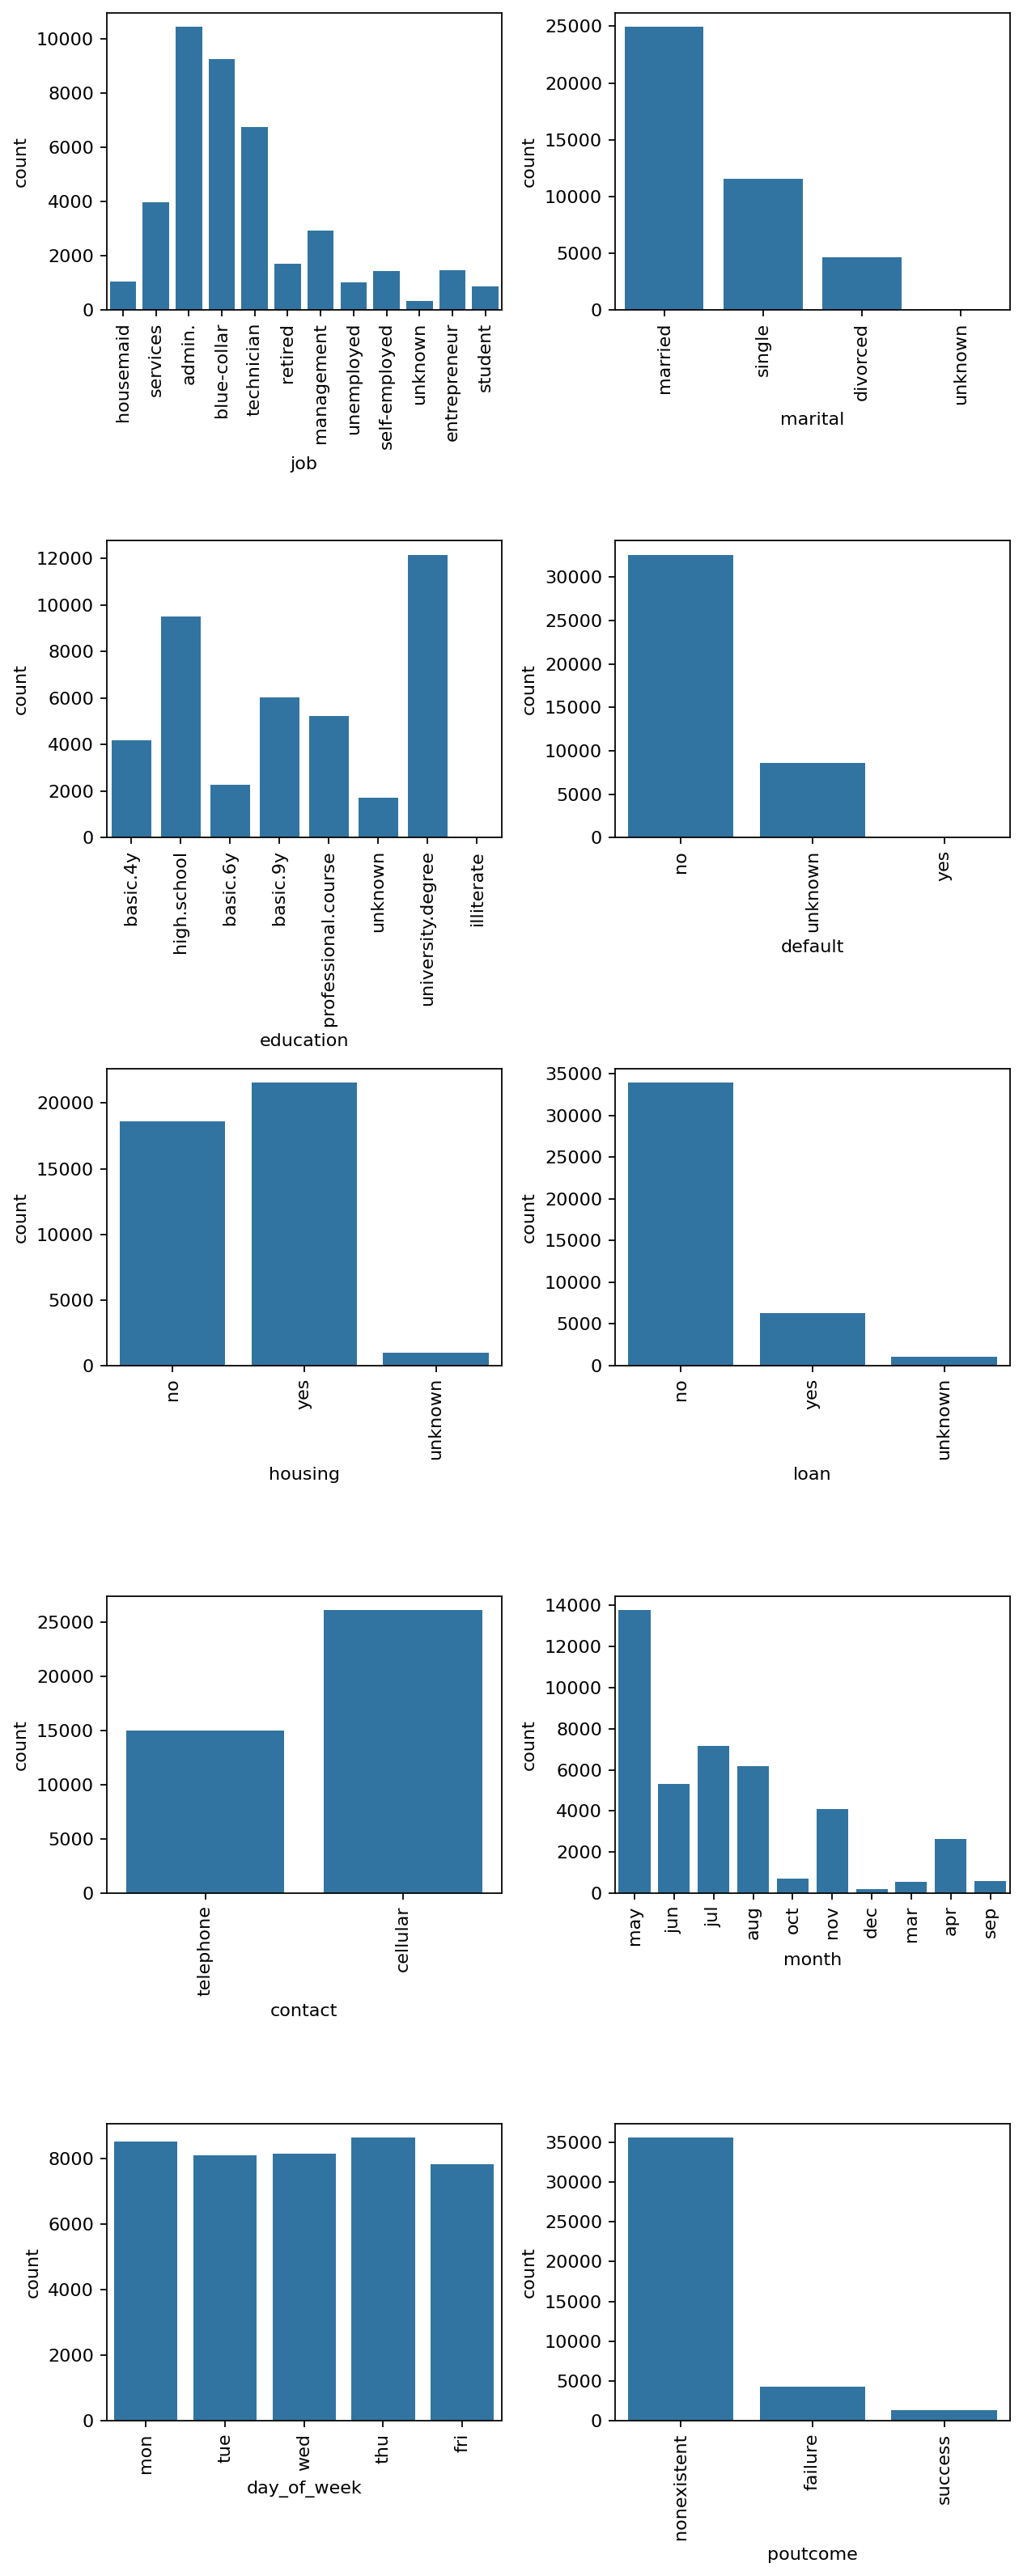

In [74]:
fig , ax = plt.subplots(ncols=2,nrows=5,figsize=(8,20),dpi=160)
row = 0
col = 0
for c in data.select_dtypes('object').columns[:-1] :
    if col>1 :
        col=0
        row+=1
    axis = ax[row,col]
    sns.countplot(data,x=c,ax=axis)
    axis.tick_params(axis='x',rotation=90)
    col+=1
plt.tight_layout()

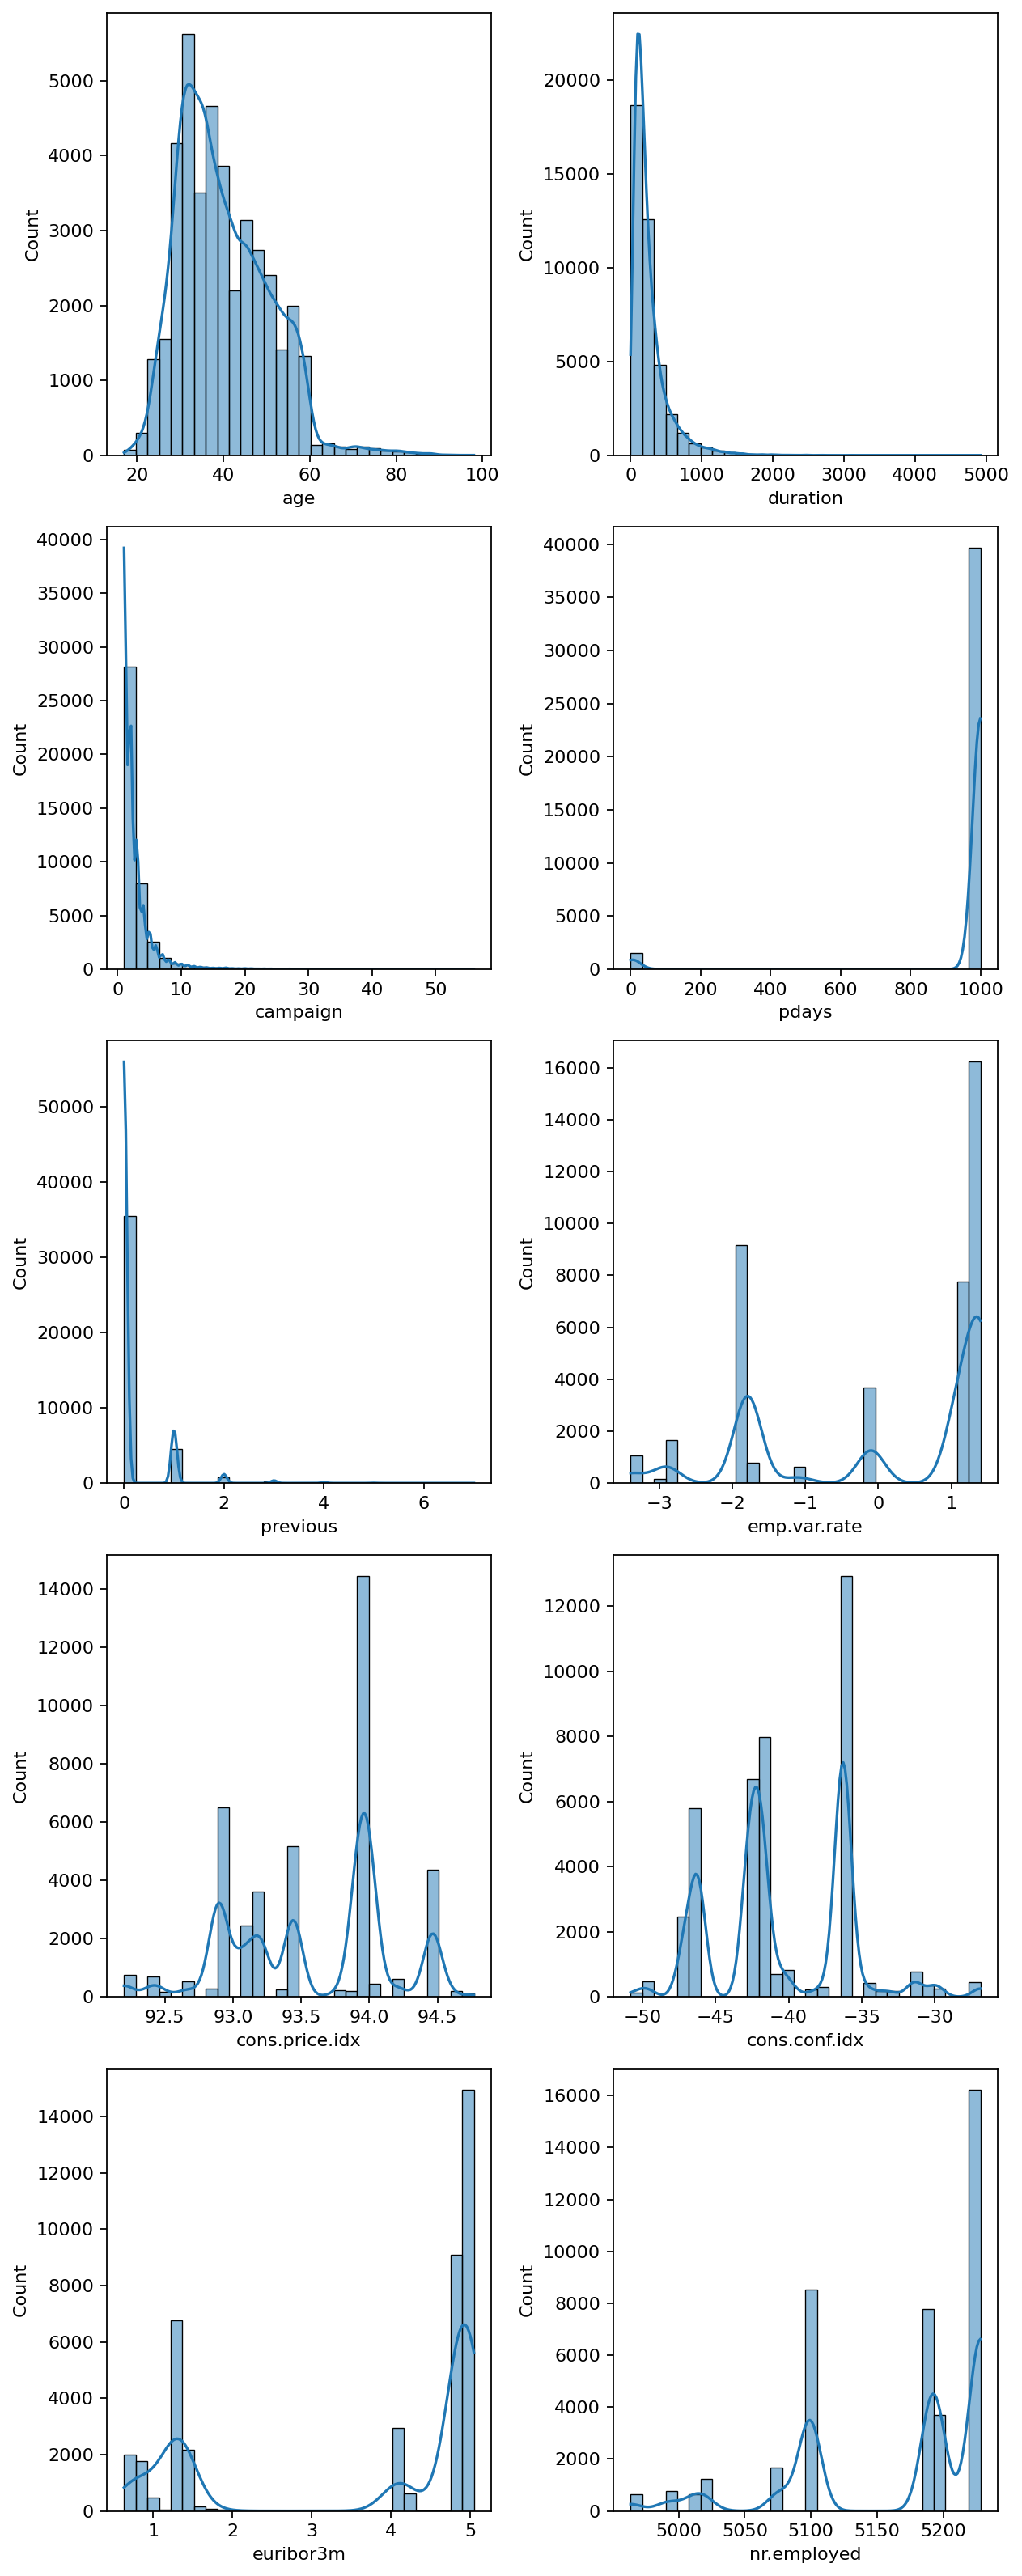

In [75]:
fig , ax = plt.subplots(ncols=2,nrows=5,figsize=(8,20),dpi=160)
row = 0
col = 0
for c in data.select_dtypes(exclude='object').columns :
    if col>1 :
        col=0
        row+=1
    axis = ax[row,col]
    sns.histplot(data,x=c,ax=axis,kde=True,bins=30)
    col+=1
plt.tight_layout()

- 변수 중 분류되지 않은 `unknown`값이 존재한다
- 캠페인은 평일에만 시행된것으로 나타난다
- 고용 변동률(emp.var.rate)이 높게 관찰돼 경제상황으로 인해 일자리 변동이 있을때 캠페인을 시행한 것으로 판단된다
- 소비자 물가지수(cons.price.idx)는 높게 관찰됐으며, 이는 상품과 서비스에 대한 지불 능력이 좋은 상태를 보여준다
- 소비자 신뢰지수(cons.conf.idx)는 낮게 관찰되어 경제 변화에 대한 신뢰도가 낮은것으로 파악된다
- 3개월 유로리보 금리는 대출금리가 높아 대출에 어려움이 있을것으로 관찰된다

-

In [76]:
fig = px.box(data, x="job", y="duration", color="y")
fig.update_traces(quartilemethod="exclusive")
fig.show()

- 정기예금 미가입자는 통화시간이 짧은것으로 관찰됐다

In [77]:
fig = px.scatter(data, x="campaign", y="duration", color="y")
fig.show()

- 마케팅 캠페인 연락 횟수가 많아질수록 통화 시간은 감소하며 부정적인결과(미가입)로 도달되고있다
- 대부분의 정기예금 가입고객은 캠페인 초기에 결정되고있다

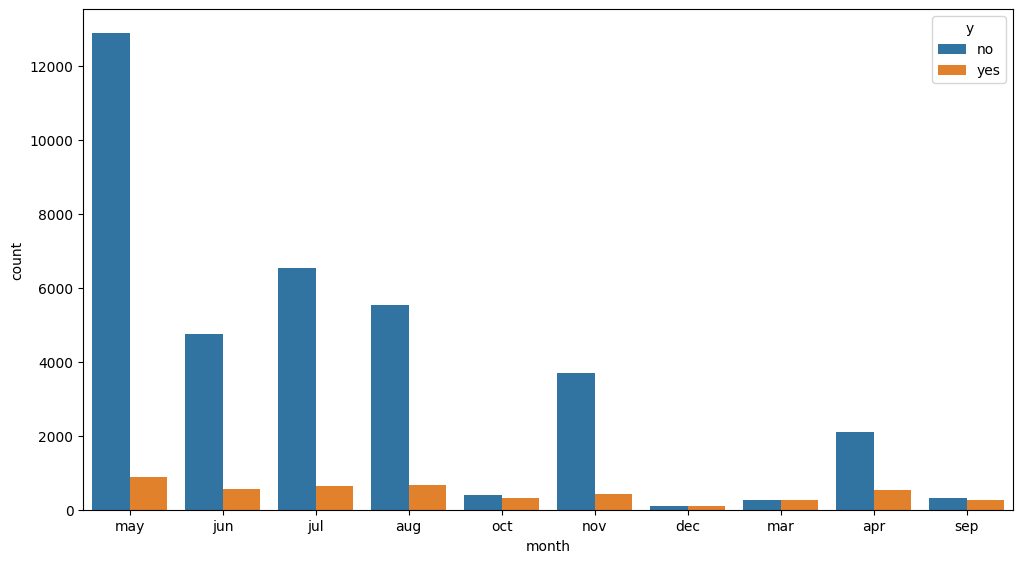

In [78]:
plt.figure(figsize=(12,6.5))
ax = sns.countplot(data = data, x = 'month', hue = 'y')

<BarContainer object of 41176 artists>

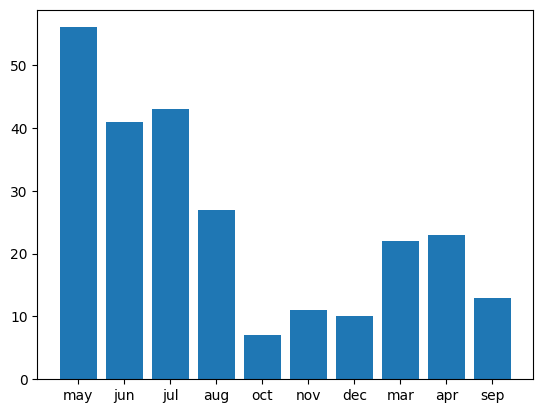

In [79]:
plt.bar(data['month'], data['campaign'])

- 캠페인은 5월, 6월, 7월에 집중되어 있다

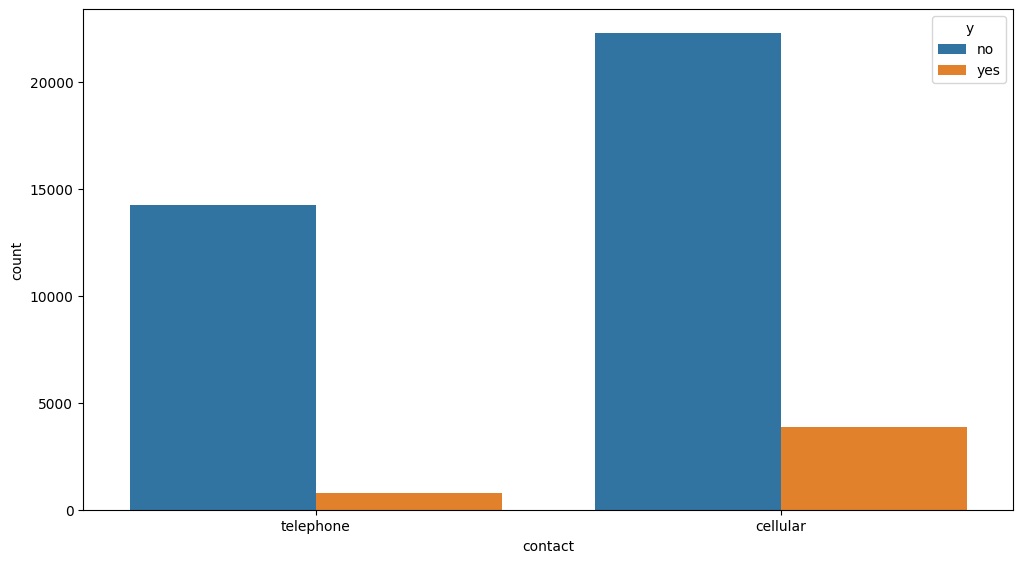

In [80]:
plt.figure(figsize=(12,6.5))
ax = sns.countplot(data = data, x = 'contact', hue = 'y')

In [81]:
data.groupby('contact')['y'].value_counts(normalize=True)

contact    y  
cellular   no     0.852611
           yes    0.147389
telephone  no     0.947676
           yes    0.052324
Name: proportion, dtype: float64

In [82]:
data[['y','contact']].loc[data['y']=='yes'].value_counts(normalize=True)

y    contact  
yes  cellular     0.830351
     telephone    0.169649
Name: proportion, dtype: float64

- 캠페인 연락유형은 cellular가 많았고, 정기예금 가입 고객도 약 15% 발생했다
- telephone을 통한 마케팅 캠페인은 가입 전환이 5%에 불과했다
- 정기예금 가입 고객중 cellular를 통해 가입한 고객이 83%를 차지했다

<Axes: xlabel='cons.price.idx', ylabel='marital'>

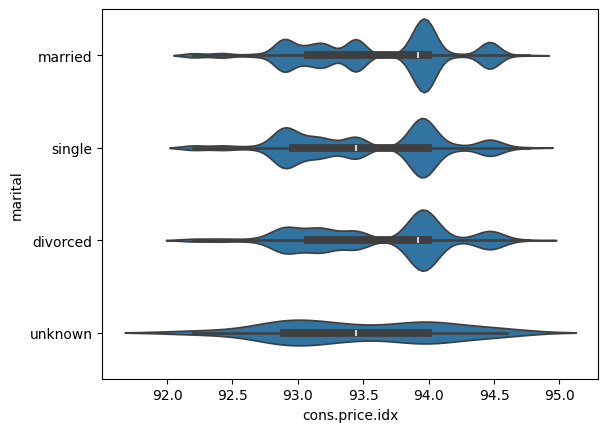

In [83]:
sns.violinplot(y=data["marital"], x=data["cons.price.idx"] )

- 결혼 여부에 따른 소비자 물가지수는 차이가 거의 없는것으로 관찰됐다

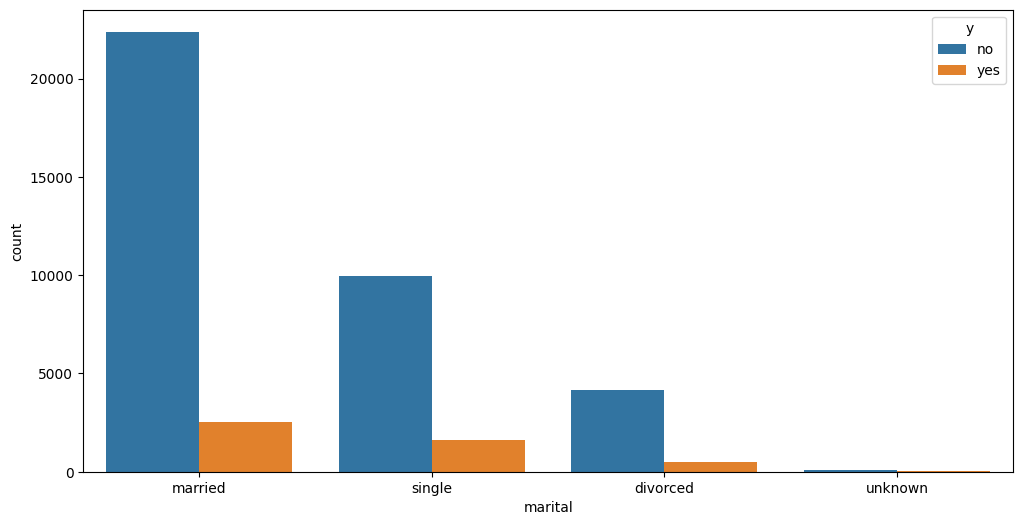

In [84]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data = data, x = 'marital', hue = 'y')

In [85]:
data.groupby('marital')['y'].value_counts(normalize=True)

marital   y  
divorced  no     0.896769
          yes    0.103231
married   no     0.898439
          yes    0.101561
single    no     0.859910
          yes    0.140090
unknown   no     0.850000
          yes    0.150000
Name: proportion, dtype: float64

- 기혼자가 정기예금 가입을 가장 많이했지만, 비율 기준으로는 기혼자(10%)보다 미혼자(14%)의 전환율이 더 높은것으로 관찰됐다

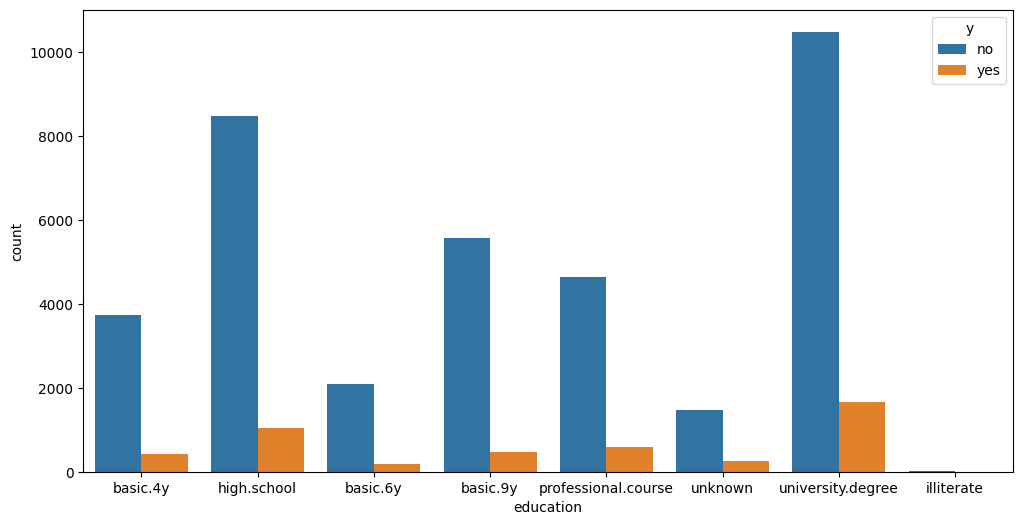

In [86]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data = data, x = 'education', hue = 'y')

In [87]:
data.groupby('education')['y'].value_counts(normalize=True)

education            y  
basic.4y             no     0.897510
                     yes    0.102490
basic.6y             no     0.917940
                     yes    0.082060
basic.9y             no     0.921754
                     yes    0.078246
high.school          no     0.891611
                     yes    0.108389
illiterate           no     0.777778
                     yes    0.222222
professional.course  no     0.886450
                     yes    0.113550
university.degree    no     0.862792
                     yes    0.137208
unknown              no     0.854913
                     yes    0.145087
Name: proportion, dtype: float64

- 대졸고객이 정기예금을 가장 많이 가입하였고, 고졸고객이 뒤따랐다

In [88]:
data['pdays']. value_counts()

pdays
999    39661
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

In [89]:
data['pdays'] = data['pdays'].astype('object')

- pdays(이전 캠페인 후 지난 일수)는 숫자 단위이지만 고객에게 연락하지 않은 데이터인 '999'값이 존재하므로 범주형으로 변환하였다

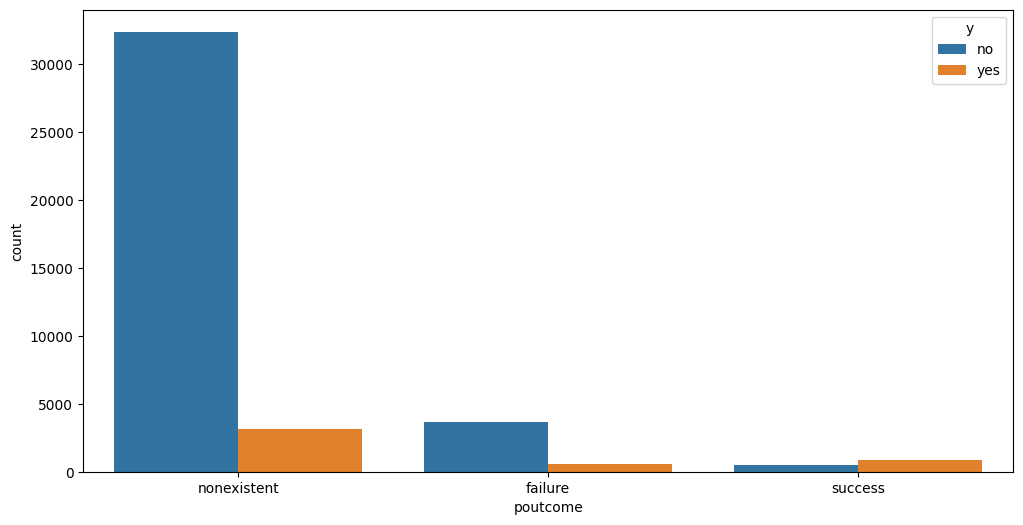

In [90]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data = data, x = 'poutcome', hue = 'y')

- 성공적인 마케팅 캠페인은 정기예금 가입 전환이 높은 반면, 실패한 캠페인의 전환율은 낮은것으로 관찰됐다. 이는 성공한 마케팅의 요인을 상세히 분석하여 고객별로 적절한 마케팅을 제안해야하는 의미를 나타내기도 한다

## 5.베이스라인 모델 구축

### 5-1.데이터 전처리

- OrdinalEncoder를 사용하여 범주형 데이터를 정수로 변환하였다

In [91]:
data.select_dtypes(exclude=['object'])

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...
41171,73,334,1,0,-1.1,94.767,-50.8,1.028,4963.6
41172,46,383,1,0,-1.1,94.767,-50.8,1.028,4963.6
41173,56,189,2,0,-1.1,94.767,-50.8,1.028,4963.6
41174,44,442,1,0,-1.1,94.767,-50.8,1.028,4963.6


In [92]:
# 범주형 열 선택
cat_columns = list(data.select_dtypes(include=['object']).columns)[:-1]
cat_columns_w_target = list(data.select_dtypes(include=['object']).columns)

# 범주형 열을 문자열로 변환
data.loc[:, cat_columns] = data.loc[:, cat_columns].astype(str)

# Ordinal Encoder 적용
enc = OrdinalEncoder()
encoded_values = enc.fit_transform(data.loc[:, cat_columns_w_target])
encoded_df = pd.DataFrame(encoded_values, columns=cat_columns_w_target)

# 인코딩된 데이터프레임으로 원본 데이터프레임 업데이트
data[cat_columns_w_target] = encoded_df

In [93]:
encoded_df

,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,poutcome,y
0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,26.0,1.0,0.0
1,7.0,1.0,3.0,1.0,0.0,0.0,1.0,6.0,1.0,26.0,1.0,0.0
2,7.0,1.0,3.0,0.0,2.0,0.0,1.0,6.0,1.0,26.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,26.0,1.0,0.0
4,7.0,1.0,3.0,0.0,0.0,2.0,1.0,6.0,1.0,26.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41171,5.0,1.0,5.0,0.0,2.0,0.0,0.0,7.0,0.0,26.0,1.0,1.0
41172,1.0,1.0,5.0,0.0,0.0,0.0,0.0,7.0,0.0,26.0,1.0,0.0
41173,5.0,1.0,6.0,0.0,2.0,0.0,0.0,7.0,0.0,26.0,1.0,0.0
41174,9.0,1.0,5.0,0.0,0.0,0.0,0.0,7.0,0.0,26.0,1.0,1.0


- 인코딩 작업후 상관관계를 확인해보니 목표변수와 주목해야할 변수는 다음과 같다
    - duration(마지막 연락 지속 시간)
    - previous(이전 캠페인 동안 연락 횟수)
    - emp.var.rate(고용 변동률)
    - euribor3m(3개월 유리보 금리)
    - nr.employed(고용자 수)

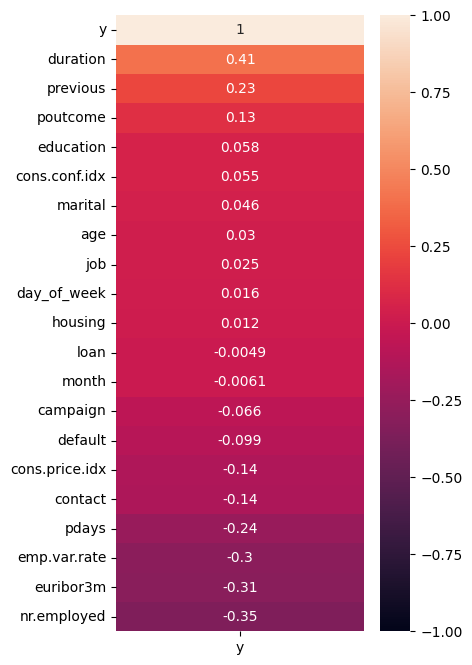

In [94]:
plt.figure(figsize=(4, 8))
heatmap = sns.heatmap(data.corr()[['y']].sort_values(by='y', ascending=False), vmin=-1, vmax=1, annot=True)

### 5-2. 데이터 분류 (훈련vs테스트)

- 훈련 데이터와 테스트 데이터를 8:2로 분류하였다

In [95]:
X = data.columns[:-1]
y = data.columns[-1]
X_train, X_test, y_train, y_test = train_test_split(data[X], data[y],
                                                    stratify = data[y],
                                                    shuffle = True,
                                                    test_size = 0.2,
                                                    random_state=2023)

- 이번 분석에서는 아래와 같은 데이터 전처리 방법을 시도하여 베이스라인 모델의 성능을 비교하고, 교차 검증과 테스트 데이터에서의 결과를 바탕으로 하이퍼파라미터 튜닝을 위한 전처리 방법을 선택할 것이다
   - 기본 데이터 : X_train, X_test, y_train, y_test
   - 스케일링된 데이터 : X_train_scale, X_test_scale, y_train, y_test
   - SMOTE를 사용한 데이터 : X_train_smote, X_test, y_train_smote, y_test
   - 스케일링과 SMOTE를 결합한 데이터 : X_train_scale_smote, X_test_scale, y_train_smote, y_test

- SMOTE는 훈련 데이터에만 적용한다. 본 분석에서는 테스트 데이터에도 목표변수가 존재하지만, 실제로는 예측을 해야하기 때문에 테스트 데이터에는 적용하지 않는다.

In [96]:
scaler = StandardScaler()
X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

num_columns = X_train_scale.select_dtypes(exclude=['object']).columns

X_train_scale[num_columns] = scaler.fit_transform(X_train_scale[num_columns])
X_test_scale[num_columns] = scaler.fit_transform(X_test_scale[num_columns])

In [97]:
smt = SMOTE(random_state=2023)

X_train_smote, y_train_smote = smt.fit_resample(X_train,y_train)
X_train_scale_smote, y_train_smote = smt.fit_resample(X_train_scale,y_train)

### 5-3.교차 검증을 통한 베이스라인 모델 구축(CatBoost, LGBM, RandomForrest)

In [98]:
X_train_smote.shape

(58458, 20)

In [99]:
X_train_scale.shape

(32940, 20)

- 데이터의 불균형으로 인해 각 클래스의 비율을 유지하면서 모델을 평가하기 위해 StratifiedKFold를 사용하여 3개의 분할로 교차 검증을 수행하고자 한다

In [100]:
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 2023)

In [101]:
a = [X_train, X_train_scale, X_train_smote, X_train_scale_smote]
b = [y_train, y_train, y_train_smote, y_train_smote]
c = [X_test, X_test_scale, X_test, X_test_scale]
d = [y_test, y_test, y_test, y_test]

- 각 모델에 대해 F1 점수를 사용하여 교차 검증을 수행하는 함수 정의하였다
- 테스트 데이터에 대한 예측을 수행한 후, 정확도와 roc auc, 정밀도, 재현율, F1 점수 계산하고자 한다

In [102]:
def cv_f1(model,X,y, X_t, y_t):
    f1_train = cross_val_score(model, X, y, scoring="f1", cv=skf)
    model.fit(X,y)
    pred = model.predict(X_t)
    f1_test = f1_score(y_t, pred)
    roc_test = roc_auc_score(y_test, pred)
    acc_test = accuracy_score(y_test, pred)
    pre_test =  precision_score(y_test, pred)
    rec_test = recall_score(y_test, pred, average='macro')
    return f1_train.mean(), f1_test, roc_test, acc_test, pre_test, rec_test

- 각 배치에 대해 성능 평가 함수를 실행하고, 모든 점수를 하나의 데이터 테이블로 정리하였다

In [103]:
cat = CatBoostClassifier(random_seed=2023, verbose=False, task_type = 'CPU')
lgbm = lgb.LGBMClassifier(random_state=2023, device = "cpu")
rf = RandomForestClassifier(random_state=2023)

train_score = []
test_score_f1 = []
test_score_roc = []
test_score_acc = []
test_score_pre = []
test_score_rec = []
for i in range(len(a)):
    score_cat = cv_f1(cat,a[i], b[i], c[i], d[i])
    train_score.append(score_cat[0])
    test_score_f1.append(score_cat[1])
    test_score_roc.append(score_cat[2])
    test_score_acc.append(score_cat[3])
    test_score_pre.append(score_cat[4])
    test_score_rec.append(score_cat[5])

    score_lgbm = cv_f1(lgbm,a[i], b[i], c[i], d[i])
    train_score.append(score_lgbm[0])
    test_score_f1.append(score_lgbm[1])
    test_score_roc.append(score_cat[2])
    test_score_acc.append(score_cat[3])
    test_score_pre.append(score_cat[4])
    test_score_rec.append(score_cat[5])

    score_rf = cv_f1(rf,a[i], b[i], c[i], d[i])
    train_score.append(score_rf[0])
    test_score_f1.append(score_rf[1])
    test_score_roc.append(score_cat[2])
    test_score_acc.append(score_cat[3])
    test_score_pre.append(score_cat[4])
    test_score_rec.append(score_cat[5])

[LightGBM] [Info] Number of positive: 2474, number of negative: 19486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 21960, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112659 -> initscore=-2.063860
[LightGBM] [Info] Start training from score -2.063860
[LightGBM] [Info] Number of positive: 2474, number of negative: 19486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 21960, number of used features: 20
[LightGBM] [Info] [bin

In [104]:
baseline_models = ['Cat_Boost_or', 'LGBM_or', 'RF_or',
                   'Cat_Boost_scale', 'LGBM_scale', 'RF_scale',
                   'Cat_Boost_smote', 'LGBM_smote', 'RF_smote',
                   'Cat_Boost_scale_smote', 'LGBM_scale_smote', 'RF_scale_smote',]
cv_score = pd.DataFrame(baseline_models, columns = ['Models'])
cv_score['F1 train cv'] = train_score
cv_score['F1 test'] = test_score_f1
cv_score['ROC AUC test'] = test_score_roc
cv_score['accuracy test'] = test_score_acc
cv_score['precision test'] = test_score_pre
cv_score['recall test'] = test_score_rec

In [105]:
cv_score.sort_values(by = 'F1 test', ascending = False)

,Models,F1 train cv,F1 test,ROC AUC test,accuracy test,precision test,recall test
7,LGBM_smote,0.951509,0.625850,0.762726,0.919500,0.670968,0.762726
8,RF_smote,0.953503,0.617450,0.762726,0.919500,0.670968,0.762726
1,LGBM_or,0.593095,0.612074,0.753062,0.920714,0.690707,0.753062
6,Cat_Boost_smote,0.950996,0.610687,0.762726,0.919500,0.670968,0.762726
0,Cat_Boost_or,0.583265,0.604002,0.753062,0.920714,0.690707,0.753062
4,LGBM_scale,0.591830,0.601571,0.758886,0.911850,0.620238,0.758886
3,Cat_Boost_scale,0.583265,0.589367,0.758886,0.911850,0.620238,0.758886
2,RF_or,0.558538,0.582725,0.753062,0.920714,0.690707,0.753062
5,RF_scale,0.559145,0.571087,0.758886,0.911850,0.620238,0.758886
11,RF_scale_smote,0.952451,0.463953,0.693829,0.456654,0.171756,0.693829


- 분석 결과   
   - 데이터 불균형 문제 : 데이터가 불균형하여 모델이 모든 예측을 'no'(0)로 할 경우에도 높은 정확도를 얻을 수 있다. 따라서 본 분석에서 정확도는 신뢰할 수 있는 성능 지표라 보기 어렵다
   - 모델의 주요 목표는 'yes'(1)클래스를 올바르게 찾아내고 예측하는 것이다. 이러한 관점에서 재현율(recall)과 정밀도(precision)는 중요한 지표라고 볼 수 있다. 재현율은 실제 True인 것 중에서 모델이 올바르게 예측한 비율, 정밀도는 모델이 True라고 분류한 것 중에서 실제로 True인 것의 비율이다.
   - F1 점수는 분류 모델에서 일반적으로 사용되는 지표로, 데이터가 불균형한 경우에도 모델의 재현율과 정밀도를 모두 평가하여 유용한 지표로 사용할 수 있다. F1 점수는 재현율과 정밀도의 조화 평균이므로, 두 지표 간의 균형을 고려하여 모델 성능을 평가할 수 있다



## 6.하이퍼파라미터 튜닝

   - F1 점수를 기준으로 볼 때, 각 모델에서 SMOTE 전처리를 적용한 모델이 가장 높은 점수를 기록하였다. 따라서 SMOTE를 사용하여 개선된 모델 성능을 바탕으로 하이퍼파라미터 튜닝을 진행하고자 한다

   - StratifiedKFold와 Optuna SearchCV를 사용하고, trials 값은 50으로 설정하였다.

In [106]:
cv_score = []
test_score_f1 = []
test_score_roc = []
test_score_accuracy = []
params = []

optuna.logging.set_verbosity(optuna.logging.INFO)
param_rf = {
            "max_depth": optuna.distributions.IntDistribution (1, 10),
            'min_samples_leaf': optuna.distributions.IntDistribution (1,6),
             'n_estimators': optuna.distributions.IntDistribution (80,200)
            }
rf = RandomForestClassifier(random_state=2023)
optuna_search = optuna.integration.OptunaSearchCV(rf,param_rf, cv=skf,
                                                  scoring='f1',n_jobs=-1,
                                                  n_trials=50,random_state=2023)

optuna_search.fit(X_train_smote, y_train_smote)
rf_fin = RandomForestClassifier(random_state=2023, **optuna_search.best_params_)
rf_fin.fit(X_train_smote,y_train_smote)
pred_rf = rf_fin.predict(X_test)
cv_score.append(optuna_search.best_score_)
test_score_f1.append(f1_score(y_test, pred_rf))
test_score_roc.append(roc_auc_score(y_test, pred_rf))
test_score_accuracy.append(accuracy_score(y_test, pred_rf))
params.append(optuna_search.best_params_)

param = {"learning_rate": optuna.distributions.FloatDistribution(0.005, 0.5),
          "n_estimators": optuna.distributions.IntDistribution(80,200),
         "colsample_bytree": optuna.distributions.FloatDistribution(0.3,1.0)}

lgbm = lgb.LGBMClassifier(random_seed=2023, device = "cpu")
optuna_search = optuna.integration.OptunaSearchCV(lgbm,param, cv=3,
                                                  scoring='f1',n_jobs=-1,
                                                  n_trials=50)
optuna_search.fit(X_train_smote,y_train_smote)
lgbm_fin = lgb.LGBMClassifier(random_state=2023, **optuna_search.best_params_)
lgbm_fin.fit(X_train_smote,y_train_smote)
pred_lgbm = lgbm_fin.predict(X_test)
cv_score.append(optuna_search.best_score_)
test_score_f1.append(f1_score(y_test, pred_lgbm))
test_score_roc.append(roc_auc_score(y_test, pred_lgbm))
test_score_accuracy.append(accuracy_score(y_test, pred_lgbm))
params.append(optuna_search.best_params_)

param = {"learning_rate": optuna.distributions.FloatDistribution(0.005, 0.5),
         "iterations": optuna.distributions.IntDistribution(300,1500),
         "depth": optuna.distributions.IntDistribution(1,10)}

cat = CatBoostClassifier(random_seed=2023, verbose=False, task_type = 'CPU')
optuna_search = optuna.integration.OptunaSearchCV(cat,param, cv=3,
                                                  scoring='f1',n_jobs=-1,
                                                  n_trials=50)
optuna_search.fit(X_train_smote,y_train_smote)
cat_fin = CatBoostClassifier(random_state=2023, verbose=False, **optuna_search.best_params_)
cat_fin.fit(X_train_smote,y_train_smote)
pred_cat = cat_fin.predict(X_test)
cv_score.append(optuna_search.best_score_)
test_score_f1.append(f1_score(y_test, pred_cat))
test_score_roc.append(roc_auc_score(y_test, pred_cat))
test_score_accuracy.append(accuracy_score(y_test, pred_cat))
params.append(optuna_search.best_params_)

ModuleNotFoundError: 
Could not find `optuna-integration` for `sklearn`.
Please run `pip install optuna-integration[sklearn]`.

In [ ]:
models = ['Random Forrest smote', 'LGBM smote', 'CatBoost smote']
fin_score = pd.DataFrame(models, columns = ['Models'])
fin_score['F1 train cv'] = cv_score
fin_score['F1 test'] = test_score_f1
fin_score['ROC AUC test'] = test_score_roc
fin_score['accuracy test'] = test_score_accuracy
fin_score['params'] = params

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
fin_score.sort_values(by = 'F1 test', ascending = False)

- 하이퍼파라미터 튜닝 결과 F1 점수 기준으로 랜덤포레스트 모델이 가장 좋은 성능을 보이고 있다
- F1 점수는 정밀도와 재현율의 조화 평균이므로, 추가적으로 confusion matrix를 살펴보고자 한다

### 6-1.랜덤포레스트

In [ ]:
print(classification_report(y_test, pred_rf))

In [ ]:
fig = px.imshow(confusion_matrix(y_test, pred_rf), text_auto=True,
               labels=dict(x="Predicted", y="Actual", color="Productivity"),
                x=['0', '1'],
                y=['0', '1'])
fig.show()

### 6-2.LGBM

In [ ]:
print(classification_report(y_test, pred_lgbm))

In [ ]:
fig = px.imshow(confusion_matrix(y_test, pred_lgbm), text_auto=True,
               labels=dict(x="Predicted", y="Actual", color="Productivity"),
                x=['0', '1'],
                y=['0', '1'])
fig.show()

### 6-3.CatBoost

In [ ]:
print(classification_report(y_test, pred_cat))

In [ ]:
fig = px.imshow(confusion_matrix(y_test, pred_cat), text_auto=True,
               labels=dict(x="Predicted", y="Actual", color="Productivity"),
                x=['0', '1'],
                y=['0', '1'])
fig.show()

### 6-4.분석결과

- 정밀도(Precision) : 랜덤포레스트와 LGBM의 0.0(음성) 클래스 정밀도가 매우 높고, 1.0(양성) 클래스의 정밀도는 모두 비슷하게 관찰됐다. LGBM이 0.0 클래스에서 가장 높은 정밀도를 보였다.

- 재현율(Recall) : 랜덤포레스트는 0.0 클래스에서 0.92, 1.0 클래스에서 0.78로 높은 재현율을 보였다. LGBM은 1.0 클래스에서 0.83으로 가장 높은 재현율을 보였다.

- F1-score : 랜덤포레스트는 0.0 클래스에서 0.94로 가장 높은 F1 점수를 보였다. 1.0 클래스에서는 랜덤포레스트가 0.65로 가장 높지만, LGBM이 0.64로 근접하게 관찰됐다. CatBoost는 1.0 클래스에서 0.61로 다소 낮은 성능을 보였다.

- 정확도(Accuracy) : 세 모델 모두 비슷한 정확도를 보이지만, CatBoost가 0.91로 가장 높게 관찰됐다.


- 결론
    - 각 모델의 성능을 종합적으로 고려할 때, 랜덤포레스트가 1.0 클래스의 재현율과 F1-score에서 가장 좋은 성능을 보였다. 그리고 LGBM도 1.0 클래스에서의 재현율은 높게 나왔고 랜덤포레스트와 비슷한 성능을 보였다. 랜덤포레스트는 가장 높은 F1점수를 보였기에 본 분석에서 가장 적합한 분류 모델이라고 볼 수 있다